In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"yukinao","key":"ffc11707b069606a7fdd4faae4c09569"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c 30-days-of-ml

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir ./kaggle
!mkdir ./kaggle/input
!mkdir ./kaggle/input/30-days-of-ml

mkdir: cannot create directory ‘./kaggle’: File exists
mkdir: cannot create directory ‘./kaggle/input’: File exists
mkdir: cannot create directory ‘./kaggle/input/30-days-of-ml’: File exists


In [ ]:
#教師データの解凍
!unzip -qq train.csv.zip -d ./kaggle/input/30-days-of-ml
!unzip -qq test.csv.zip -d ./kaggle/input/30-days-of-ml

replace ./kaggle/input/30-days-of-ml/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace ./kaggle/input/30-days-of-ml/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import random

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font='Yu Gothic')

from pathlib import Path
input_path = Path('./kaggle/input/30-days-of-ml/')

In [ ]:
train = pd.read_csv(input_path / 'train.csv')
test = pd.read_csv(input_path / 'test.csv')

In [ ]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cont0   300000 non-null  float64
 12  cont1   300000 non-null  float64
 13  cont2   300000 non-null  float64
 14  cont3   300000 non-null  float64
 15  cont4   300000 non-null  float64
 16  cont5   300000 non-null  float64
 17  cont6   300000 non-null  float64
 18  cont7   300000 non-null  float64
 19  cont8   300000 non-null  float64
 20  cont9   300000 non-null  float64
 21  cont10  30

In [ ]:
test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,B,B,B,C,B,B,A,E,E,I,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,5,A,B,A,C,B,C,A,E,C,H,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,15,B,A,A,A,B,B,A,E,D,K,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,16,B,B,A,C,B,D,A,E,A,N,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,17,B,B,A,C,B,C,A,E,C,F,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [ ]:
# define the features for convenience.
CAT_FEATS = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
NUM_FEATS = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']
ALL_FEATS = CAT_FEATS + NUM_FEATS

N_FOLDS = 10
SEED = 42

Preprocess

In [ ]:
# Merge
train['ISTrain'] = 1
test['ISTrain'] = 0
data = pd.concat([train, test])

In [ ]:
# Category
for cat in CAT_FEATS:
    le = LabelEncoder()
    data[cat] = le.fit_transform(data[cat])

In [ ]:
# Undo
train = data[data['ISTrain'] == 1]
test = data[data['ISTrain'] != 1]

In [ ]:
#drop
drop_cols = ["ISTrain"]
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [ ]:
drop_cols = ["id"]
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

Stratified KFolds

In [ ]:
def create_stratified_folds_for_regression(data_df, n_splits=5):
    """
    @param data_df: training data to split in Stratified K Folds for a continous target value
    @param n_splits: number of splits
    @return: the training data with a column with kfold id
    """
    data_df['kfold'] = -1
    # randomize the data
    data_df = data_df.sample(frac=1).reset_index(drop=True)
    # calculate the optimal number of bins based on log2(data_df.shape[0])
    num_bins = np.int(np.floor(1 + np.log2(len(data_df))))
    print(f"Num bins: {num_bins}")
    # bins value will be the equivalent of class value of target feature used by StratifiedKFold to 
    # distribute evenly the classed over each fold
    data_df.loc[:, "bins"] = pd.cut(pd.to_numeric(data_df['target'], downcast="signed"), bins=num_bins, labels=False)
    kf = model_selection.StratifiedKFold(n_splits=n_splits)
    
    # set the fold id as a new column in the train data
    for f, (t_, v_) in enumerate(kf.split(X=data_df, y=data_df.bins.values)):
        data_df.loc[v_, 'kfold'] = f
    
    # drop the bins column (no longer needed)
    data_df = data_df.drop("bins", axis=1)
    
    return data_df

In [ ]:
n_splits = N_FOLDS
train = create_stratified_folds_for_regression(train, n_splits)

Num bins: 19


In [ ]:
train.kfold.value_counts()

9    30000
8    30000
7    30000
6    30000
5    30000
4    30000
3    30000
2    30000
1    30000
0    30000
Name: kfold, dtype: int64

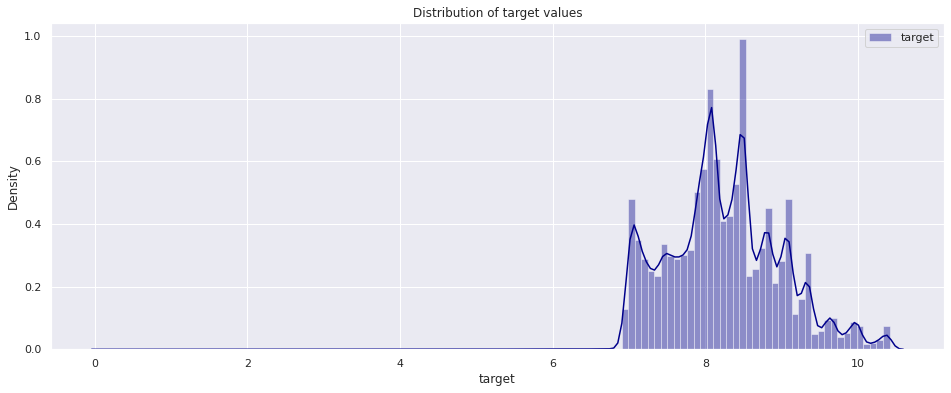

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of target values")
sns.distplot(train['target'],color="darkblue", kde=True,bins=120, label='target')
plt.legend(); plt.show()

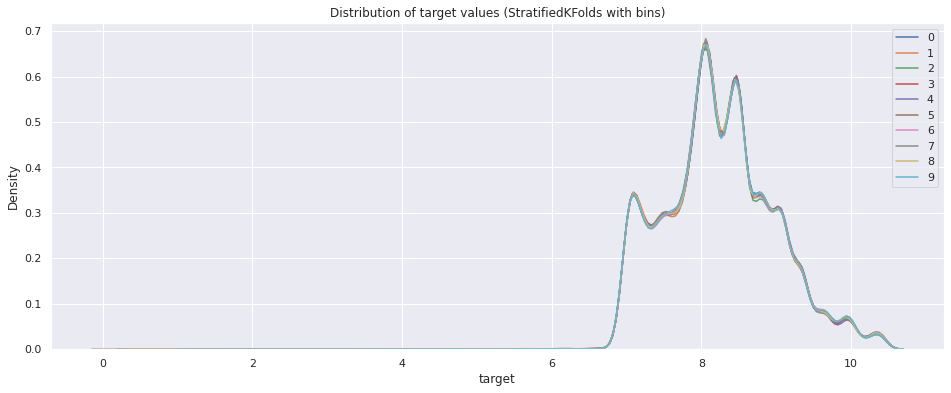

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of target values (StratifiedKFolds with bins)")
for k in range(0,n_splits):
    df = train.loc[train.kfold==k]
    sns.distplot(df['target'],kde=True,hist=False, bins=120, label=k)
plt.legend(); plt.show()

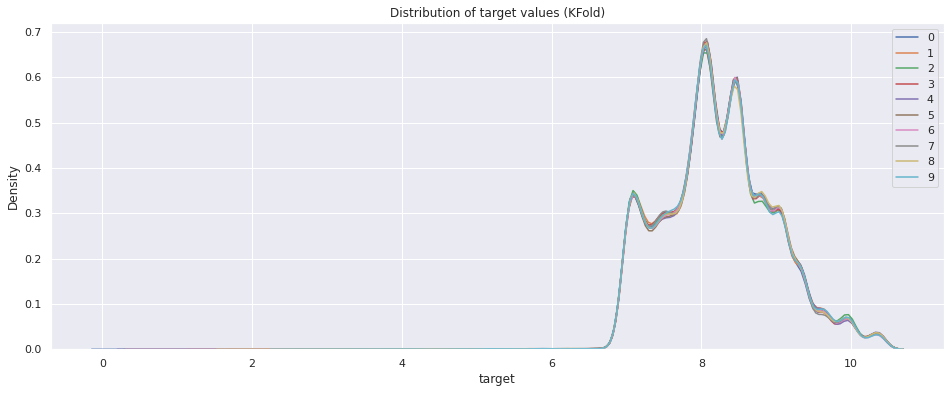

In [ ]:
kf = model_selection.KFold(n_splits=n_splits)

plt.figure(figsize=(16,6))
plt.title("Distribution of target values (KFold)")
    
for f, (t_, v_) in enumerate(kf.split(X=train)):
    df = train.iloc[v_]
    sns.distplot(df['target'],kde=True,hist=False, bins=120, label=f)
    
plt.legend(); plt.show() 

In [ ]:
def kfold_splits(n_splits, train_df):
    """
    Returns a collection of (fold, train indexes, validation indexes)
    @param n_splits: number of splits
    @param train_df: training data
    @return: a collection of (fold, train indexes, validation indexes)
    """
    all_folds = list(range(0, n_splits))
    kf_splits = []
    for fold in range(0, n_splits):
        train_folds = [x for x in all_folds if x != fold]
        trn_idx = train_df[train_df.kfold!=fold].index
        val_idx = train_df[train_df.kfold==fold].index
        kf_splits.append((fold, trn_idx, val_idx))
    return kf_splits

In [ ]:
target_col = "target"
target = train[target_col]
train.drop(columns=[target_col], inplace=True)
test.drop(columns=[target_col], inplace=True)

LightGBM

In [ ]:
from sklearn.metrics import accuracy_score
import lightgbm as lgb

In [ ]:
# LGBMのパラメータを設定
LGBM_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.001,
    "num_leaves": 1024,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.95,
    #"min_child_samples": 290,
    #"reg_alpha": 9.562925363678952,
    #"reg_lambda": 9.355810045480153,
    #"max_bin": 772,
    #"min_data_per_group": 177,
    #"bagging_freq": 1,
    #"cat_smooth": 96,
    #"cat_l2": 17,
    "verbosity": -1,
    "bagging_seed": SEED,
    "feature_fraction_seed": SEED,
    "seed": SEED
}

In [ ]:
#KFold
#kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# RMSE用
LGBM_score = 0

# testデータの予測用
LGBM_pred = np.zeros(test.shape[0])

In [ ]:
for fold_, train_index, valid_index in kfold_splits(n_splits, train):

    train_x = train.iloc[train_index][ALL_FEATS]
    valid_x = train.iloc[valid_index][ALL_FEATS]
    train_y = target[train_index]
    valid_y = target[valid_index]

    ########
    # LGBM #
    ########
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(valid_x,valid_y)
   
    LGBM_model = lgb.train(LGBM_params,
                  lgb_train,
                  valid_names=['train', 'valid'],
                  valid_sets=[lgb_train, lgb_valid],
                  num_boost_round=10000,
                  early_stopping_rounds=100,
                  feature_name=ALL_FEATS,
                  categorical_feature=CAT_FEATS, # categorical features
                  verbose_eval=500)
    
    # predictions in test data 
    LGBM_test_pred = LGBM_model.predict(test,num_iteration=LGBM_model.best_iteration)
    # 0より小さな値があるとエラーになるので補正
    LGBM_test_pred = np.where(LGBM_test_pred < 0, 0, LGBM_test_pred)
    LGBM_pred += LGBM_test_pred / N_FOLDS  #  fold回すので
    
    # logging
    LGBM_score += LGBM_model.best_score["valid"]["rmse"] / N_FOLDS
    print("LGBM_END\n")

Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.726457	valid's rmse: 0.737527
[1000]	train's rmse: 0.709924	valid's rmse: 0.732919
[1500]	train's rmse: 0.69544	valid's rmse: 0.729875
[2000]	train's rmse: 0.682236	valid's rmse: 0.727769
[2500]	train's rmse: 0.670008	valid's rmse: 0.726261
[3000]	train's rmse: 0.658399	valid's rmse: 0.725139
[3500]	train's rmse: 0.647287	valid's rmse: 0.724244
[4000]	train's rmse: 0.636653	valid's rmse: 0.723566
[4500]	train's rmse: 0.626423	valid's rmse: 0.723056
[5000]	train's rmse: 0.616629	valid's rmse: 0.722628


KeyboardInterrupt: ignored

In [ ]:
#prediction
pred = LGBM_pred
print(f"Mean RMSE SCORE :{LGBM_score}")

Mean RMSE SCORE :0.7173708670186565


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

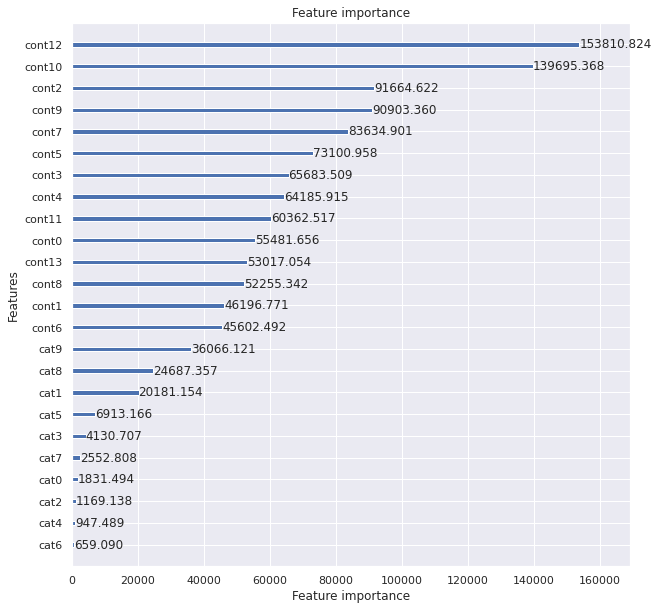

In [ ]:
# 特徴量の重要度をプロットする
# plot importance
lgb.plot_importance(LGBM_model,importance_type="gain", figsize=(10,10))

CPU times: user 19.8 s, sys: 330 ms, total: 20.1 s
Wall time: 11 s


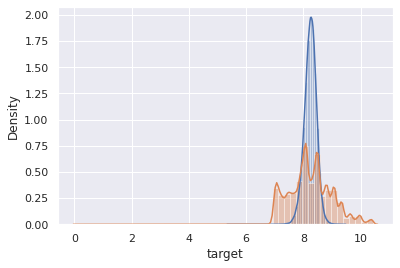

In [ ]:
# Model
%%time
LGBM_test_pred = LGBM_model.predict(train[ALL_FEATS], num_iteration=LGBM_model.best_iteration)
tea_ans = target

# draw a comparison between train and target
sns.distplot(LGBM_test_pred)
sns.distplot(target)

In [ ]:
# make submission file
sub = pd.read_csv(input_path / 'sample_submission.csv')
sub['target'] = pred
sub.to_csv('20210817_SFK_LGBM_submission.csv', index=False)
sub.head()

,id,target
0,0,8.057624
1,5,8.340325
2,15,8.369175
3,16,8.461016
4,17,8.143834
